# Project Overview

### Purpose of the Project  
This project aims to provide a hands-on introduction to the general workflow of Data Science (DS) and Machine Learning (ML), which has become a cornerstone framework for modern actuarial pricing methodologies. Accurate pricing remains a critical challenge for the insurance industry, where precise loss cost estimates are essential for effective portfolio management and maintaining financial stability. The urgency of this issue is underscored by the increasing volume of claims, such as those related to business interruptions—a significant consequence of the COVID-19 pandemic.

As part of this project, a case study will explore supervised ML techniques for predicting claim severities using a French motor third-party liability (MTPL) insurance dataset. While this case study may not directly address the most immediate pricing challenges faced by actuaries today, the project aims to demonstrate the potential of advanced analytical and computational methods in transforming the insurance sector. It advocates for preparing the industry to meet future demands with innovative, data-driven solutions.

### Key Highlights of the Project  
This project will focus on the following components:  
1. **Data Preprocessing and Encoding**: Preparing the MTPL insurance dataset by cleaning and encoding the data for effective analysis.  
2. **Feature Selection**: Identifying and selecting the most significant risk factors from the dataset.  
3. **Model Training and Testing**: Applying a variety of ML regression models to predict claim severities based on the chosen risk features.  
---

### Step-1: Imports
---

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # graphs/plotting
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import TweedieRegressor
from xgboost import XGBRegressor

# Import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
## Load the CSV data files into Pandas dataframes.

MTPL_filepath = "/kaggle/input/fremtpl-french-motor-tpl-insurance-claims/"

print("Now loading MTPLfreq.")
MTPLfreq = pd.read_csv(MTPL_filepath+"freMTPLfreq.csv")
print("MTPLfreq was loaded.\n")

print("Now loading MTPLsev.")
MTPLsev = pd.read_csv(MTPL_filepath+"freMTPLsev.csv")
print("MTPLsev was loaded.\n")

Now loading MTPLfreq.
MTPLfreq was loaded.

Now loading MTPLsev.
MTPLsev was loaded.



In [3]:
# Check for total amount of claims paid in original DataFrame, prior to merging MTPLfreq with MTPLsev.

print(sum(MTPLsev['ClaimAmount']))

# Aggregate the claim amounts by PolicyID, prior to merging MTPLfreq with MTPLsev.

MTPLsev_grp = MTPLsev.groupby(['PolicyID'])[['ClaimAmount']].agg('sum').reset_index()

# Perform an outer merge between MTPLfreq/MTPLsev, based on PolicyID, then reset the index back to PolicyID (this is dropped during merging).

df_merged = pd.merge(MTPLfreq, MTPLsev_grp, how='outer', on='PolicyID').fillna(0).set_index('PolicyID')

# Check for the total amount of claims paid in new DataFrame, after merging MTPLfreq with MTPLsev.

print(sum(df_merged['ClaimAmount']))

34465077
34465077.0


### Step-2: Exploratory Data Analysis
---

**Understanding the columns and their datatypes**

In [4]:
print(df_merged.columns)
print('\n')
print(df_merged.dtypes)
print('\n')

Index(['ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge', 'Brand', 'Gas',
       'Region', 'Density', 'ClaimAmount'],
      dtype='object')


ClaimNb          int64
Exposure       float64
Power           object
CarAge           int64
DriverAge        int64
Brand           object
Gas             object
Region          object
Density          int64
ClaimAmount    float64
dtype: object




From the code above, we can see that we have a variety of datatypes within our dataframe - the columns with `object` dtype contain non-numerical (character) data, which will need to be pre-processed in order for these to be machine-interpretable.

This will be explained in further detail later on.

**First 5 rows of the MTPL dataset**

In [5]:
print(df_merged.head())
print('\n')

          ClaimNb  Exposure Power  CarAge  DriverAge  \
PolicyID                                               
1               0      0.09     g       0         46   
2               0      0.84     g       0         46   
3               0      0.52     f       2         38   
4               0      0.45     f       2         38   
5               0      0.15     g       0         41   

                                       Brand      Gas              Region  \
PolicyID                                                                    
1         Japanese (except Nissan) or Korean   Diesel           Aquitaine   
2         Japanese (except Nissan) or Korean   Diesel           Aquitaine   
3         Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais   
4         Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais   
5         Japanese (except Nissan) or Korean   Diesel    Pays-de-la-Loire   

          Density  ClaimAmount  
PolicyID                        
1

**How many policyholders have made zero claims? How will this affect the choice of model that we use to estimate claim severity?**

In [6]:
policies_no_claims = len(df_merged.loc[df_merged['ClaimNb'] == 0].index)
all_policies = len(df_merged.index)

pct_pols_no_clm = round((policies_no_claims/all_policies)*100, 2) 

print(str(pct_pols_no_clm)+"% of policyholders have not made any claims.")

96.28% of policyholders have not made any claims.


Since the majority of policyholders have not filed any claims, the `ClaimAmount` distribution is expected to exhibit a significant peak at zero, accompanied by a right-skewed tail representing positive claim amounts with a probability that decreases exponentially.  

Therefore, the linear regression model we select must effectively capture and accommodate both the sharp concentration around zero and the skewed tail of the `ClaimAmount` distribution.

### Step 3: Added Features
---

In [7]:
df_merged['ClaimFreq'] = df_merged['ClaimNb'] / df_merged['Exposure']

df_merged['ClaimSev'] = df_merged['ClaimAmount'] / df_merged['Exposure']

### Step 4: Perform a train-test split
---

Next - we will create separate DataFrames that will store the features and target variables. These are then supplied to the `sklearn` function `train_test_split()` in order to split the data into training/test subsets, for the reason outlined above.

In [ ]:
# Assign the target variable 
y_full = df_merged.ClaimAmount
X_full = df_merged.drop(['ClaimAmount', 'ClaimSev'], axis=1)
print(y_full.head())
print(X_full.head())


X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2, random_state=1)

PolicyID
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: ClaimAmount, dtype: float64
          ClaimNb  Exposure Power  CarAge  DriverAge  \
PolicyID                                               
1               0      0.09     g       0         46   
2               0      0.84     g       0         46   
3               0      0.52     f       2         38   
4               0      0.45     f       2         38   
5               0      0.15     g       0         41   

                                       Brand      Gas              Region  \
PolicyID                                                                    
1         Japanese (except Nissan) or Korean   Diesel           Aquitaine   
2         Japanese (except Nissan) or Korean   Diesel           Aquitaine   
3         Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais   
4         Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais   
5         Japanese (except Nissan) or Korean   Diesel    

### Step 5: Encode categorical variables for modelling
---

**Label Encoding**


In [ ]:
# Make a copy of the training/validation feature subsets to avoid changing any original data.
copy_X_train = X_train.copy()
copy_X_valid = X_valid.copy()

# Apply a label encoder to the 'Power' column (i.e. encoding of ordinal variable).
label_encoder = LabelEncoder()

copy_X_train['Power'] = label_encoder.fit_transform(X_train['Power'])
copy_X_valid['Power'] = label_encoder.transform(X_valid['Power'])

**One-Hot Encoding**


In [ ]:


OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = ['Brand', 'Gas', 'Region']

## 'handle_unknown="ignore"' prevents errors when unseen categories appear in the validation set.
## 'sparse=False' ensures the output is a dense numpy array instead of a sparse matrix.

# Transform the categorical columns into one-hot encoded arrays.
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(copy_X_train[OH_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(copy_X_valid[OH_cols]))

# Reassign the original indices after transformation.
OH_cols_train.index = copy_X_train.index
OH_cols_valid.index = copy_X_valid.index

# Assign proper column names from the encoder's feature names.
OH_cols_train.columns = OH_encoder.get_feature_names(OH_cols)
OH_cols_valid.columns = OH_encoder.get_feature_names(OH_cols)

# Create dataframes excluding the original categorical columns.
copy_X_train_no_OH_cols = copy_X_train.drop(OH_cols, axis=1)
copy_X_valid_no_OH_cols = copy_X_valid.drop(OH_cols, axis=1)

# Combine the one-hot encoded columns with the remaining numerical features.
X_train_enc = pd.concat([copy_X_train_no_OH_cols, OH_cols_train], axis=1)
X_valid_enc = pd.concat([copy_X_valid_no_OH_cols, OH_cols_valid], axis=1)


**Data scaling - normalisation**
> Perform min-max scaling on the encoded dataset, such that all features lie between 0 and 1

In [ ]:
MM_scaler = MinMaxScaler()
MM_scaler.fit(X_train_enc)

X_train_scale = pd.DataFrame(MM_scaler.transform(X_train_enc),
                             index=X_train_enc.index,
                             columns=X_train_enc.columns)

X_valid_scale = pd.DataFrame(MM_scaler.transform(X_valid_enc),
                             index=X_valid_enc.index,
                             columns=X_valid_enc.columns)

In [12]:
# Verify minimum value of all features in X_train_scale:

X_train_scale.min(axis=0)

ClaimNb                                     0.0
Exposure                                    0.0
Power                                       0.0
CarAge                                      0.0
DriverAge                                   0.0
Density                                     0.0
ClaimFreq                                   0.0
Brand_Fiat                                  0.0
Brand_Japanese (except Nissan) or Korean    0.0
Brand_Mercedes, Chrysler or BMW             0.0
Brand_Opel, General Motors or Ford          0.0
Brand_Renault, Nissan or Citroen            0.0
Brand_Volkswagen, Audi, Skoda or Seat       0.0
Brand_other                                 0.0
Gas_Diesel                                  0.0
Gas_Regular                                 0.0
Region_Aquitaine                            0.0
Region_Basse-Normandie                      0.0
Region_Bretagne                             0.0
Region_Centre                               0.0
Region_Haute-Normandie                  

In [13]:
# Verify maximum value of all features in X_train_scale:

X_train_scale.max(axis=0)

ClaimNb                                     1.0
Exposure                                    1.0
Power                                       1.0
CarAge                                      1.0
DriverAge                                   1.0
Density                                     1.0
ClaimFreq                                   1.0
Brand_Fiat                                  1.0
Brand_Japanese (except Nissan) or Korean    1.0
Brand_Mercedes, Chrysler or BMW             1.0
Brand_Opel, General Motors or Ford          1.0
Brand_Renault, Nissan or Citroen            1.0
Brand_Volkswagen, Audi, Skoda or Seat       1.0
Brand_other                                 1.0
Gas_Diesel                                  1.0
Gas_Regular                                 1.0
Region_Aquitaine                            1.0
Region_Basse-Normandie                      1.0
Region_Bretagne                             1.0
Region_Centre                               1.0
Region_Haute-Normandie                  

In [14]:
# Verify minimum value of all features:

X_valid_scale.min(axis=0)

ClaimNb                                     0.0
Exposure                                    0.0
Power                                       0.0
CarAge                                      0.0
DriverAge                                   0.0
Density                                     0.0
ClaimFreq                                   0.0
Brand_Fiat                                  0.0
Brand_Japanese (except Nissan) or Korean    0.0
Brand_Mercedes, Chrysler or BMW             0.0
Brand_Opel, General Motors or Ford          0.0
Brand_Renault, Nissan or Citroen            0.0
Brand_Volkswagen, Audi, Skoda or Seat       0.0
Brand_other                                 0.0
Gas_Diesel                                  0.0
Gas_Regular                                 0.0
Region_Aquitaine                            0.0
Region_Basse-Normandie                      0.0
Region_Bretagne                             0.0
Region_Centre                               0.0
Region_Haute-Normandie                  

In [15]:
# Verify maximum value of all features:

X_valid_scale.max(axis=0)

ClaimNb                                     1.000000
Exposure                                    0.718206
Power                                       1.000000
CarAge                                      1.000000
DriverAge                                   1.000000
Density                                     1.000000
ClaimFreq                                   1.000000
Brand_Fiat                                  1.000000
Brand_Japanese (except Nissan) or Korean    1.000000
Brand_Mercedes, Chrysler or BMW             1.000000
Brand_Opel, General Motors or Ford          1.000000
Brand_Renault, Nissan or Citroen            1.000000
Brand_Volkswagen, Audi, Skoda or Seat       1.000000
Brand_other                                 1.000000
Gas_Diesel                                  1.000000
Gas_Regular                                 1.000000
Region_Aquitaine                            1.000000
Region_Basse-Normandie                      1.000000
Region_Bretagne                             1.

### Step-6: Descriptive Stats 
---

In [16]:
print(df_merged.describe())

             ClaimNb       Exposure         CarAge      DriverAge  \
count  413169.000000  413169.000000  413169.000000  413169.000000   
mean        0.039163       0.561088       7.532404      45.319876   
std         0.204053       0.369477       5.763011      14.328120   
min         0.000000       0.002732       0.000000      18.000000   
25%         0.000000       0.200000       3.000000      34.000000   
50%         0.000000       0.540000       7.000000      44.000000   
75%         0.000000       1.000000      12.000000      54.000000   
max         4.000000       1.990000     100.000000      99.000000   

             Density   ClaimAmount      ClaimFreq      ClaimSev  
count  413169.000000  4.131690e+05  413169.000000  4.131690e+05  
mean     1985.153913  8.341642e+01       0.118803  3.711403e+02  
std      4776.254543  4.192526e+03       2.155181  3.493029e+04  
min         2.000000  0.000000e+00       0.000000  0.000000e+00  
25%        67.000000  0.000000e+00       0.00000

In [17]:
desc_pairplot_x_vars_A = ['ClaimNb', 'Power', 'CarAge', 'DriverAge', 'Brand', 'Gas', 'Density']

desc_pairplot_x_vars_B = ['Power', 'CarAge', 'DriverAge', 'Brand', 'Gas', 'Density']

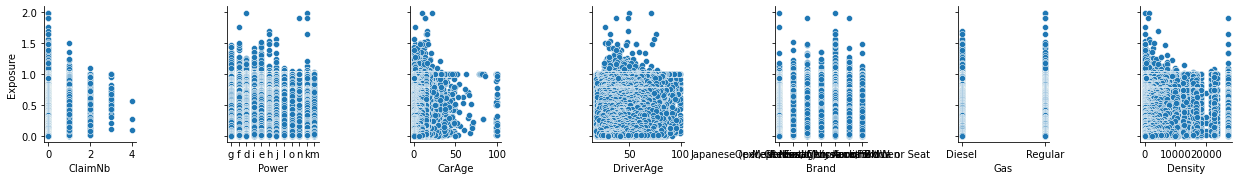

In [18]:
# Pairplot 1 - Exposure vs. x_vars.

desc_pairplot_1 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_A, y_vars='Exposure')

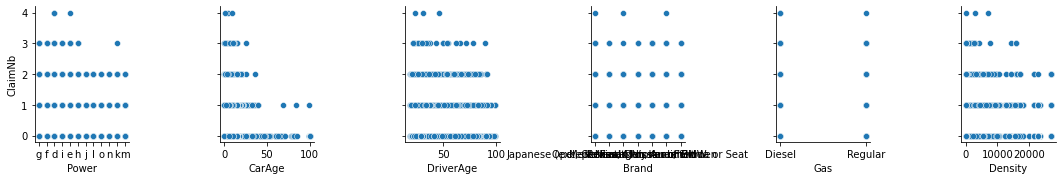

In [19]:
# Pairplot 2 - ClaimNb vs. x_vars.

desc_pairplot_2 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_B, y_vars='ClaimNb')

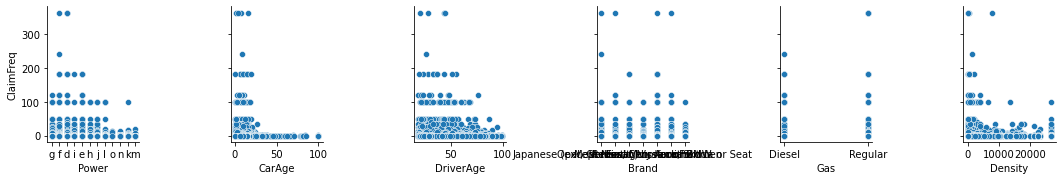

In [20]:
# Pairplot 3 - ClaimFreq vs. x_vars (i.e. accounting for policy exposure weighting).

desc_pairplot_3 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_B, y_vars='ClaimFreq')

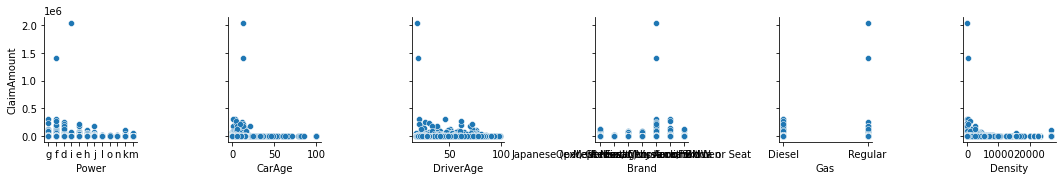

In [21]:
# Pairplot 4 - ClaimAmount vs. x_vars.

desc_pairplot_4 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_B, y_vars='ClaimAmount')

* What distribution does ClaimAmount have?
> ClaimAmount has a positive continuous distribution (non-negative, for this dataset) which is centred at 0 (a majority of policyholders do not make any claims). Hence, using an ordinary linear regression model that treats the response variable's distribution as normal/Gaussian would not be appropriate, due to the asymmetry in the probability distribution of ClaimAmount as described.

* How will the distribution of this response variable affect the choice of regressors used for modelling claim severity?
> As claim severity will need to be modelled via asymmetric/skewed distributions, we will need to consider regression approaches using generalised linear models which allow for response variables to have distributions that are non-normal, as well as other regressors that are capable of generalising in an agnostic manner (i.e. these do not require the underlying distribution of the response variable to be pre-defined). These methods are considered in further detail within Step 9.

### Step 7: Feature Selection
---

Use `Lasso Regrssion (L1 Regularization)`

In [ ]:


# Establish the Lasso (L1) Regularisation model that will perform feature selection.
lasso = Lasso(alpha=5e-5, random_state=1, max_iter=1e+6).fit(X_train_scale, y_train)
model = SelectFromModel(lasso, prefit=True)

X_train_l1 = model.transform(X_train_scale)

selected_features = pd.DataFrame(model.inverse_transform(X_train_l1),
                                index=X_train_scale.index,
                                columns=X_train_scale.columns)

print(selected_features)

          ClaimNb  Exposure     Power  CarAge  DriverAge   Density  ClaimFreq  \
PolicyID                                                                        
194119       0.00  0.240163  0.181818    0.07   0.407407  0.152826   0.000000   
293687       0.00  0.501829  0.272727    0.13   0.358025  0.004667   0.000000   
132615       0.25  0.199907  0.090909    0.09   0.333333  1.000000   0.006849   
138539       0.00  0.290483  0.090909    0.04   0.172840  0.029632   0.000000   
217750       0.00  0.260291  0.181818    0.11   0.111111  0.018631   0.000000   
...           ...       ...       ...     ...        ...       ...        ...   
73350        0.00  0.501829  0.181818    0.09   0.567901  0.002630   0.000000   
371404       0.00  0.209971  0.545455    0.01   0.111111  1.000000   0.000000   
312202       0.00  0.189842  0.000000    0.01   0.481481  1.000000   0.000000   
267337       0.00  0.089202  0.000000    0.12   0.456790  0.005223   0.000000   
128038       0.00  0.501829 

In [24]:
selected_columns = selected_features.columns[selected_features.var() != 0]

print(selected_columns)

Index(['ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge', 'Density',
       'ClaimFreq', 'Brand_Fiat', 'Brand_Japanese (except Nissan) or Korean',
       'Brand_Mercedes, Chrysler or BMW', 'Brand_Opel, General Motors or Ford',
       'Brand_Renault, Nissan or Citroen', 'Brand_other', 'Gas_Diesel',
       'Region_Aquitaine', 'Region_Basse-Normandie', 'Region_Bretagne',
       'Region_Centre', 'Region_Haute-Normandie', 'Region_Limousin',
       'Region_Nord-Pas-de-Calais', 'Region_Pays-de-la-Loire',
       'Region_Poitou-Charentes'],
      dtype='object')


In [25]:
X_train_L1reg = selected_features.drop(selected_features.columns[selected_features.var() == 0], axis=1)

print(X_train_L1reg)

          ClaimNb  Exposure     Power  CarAge  DriverAge   Density  ClaimFreq  \
PolicyID                                                                        
194119       0.00  0.240163  0.181818    0.07   0.407407  0.152826   0.000000   
293687       0.00  0.501829  0.272727    0.13   0.358025  0.004667   0.000000   
132615       0.25  0.199907  0.090909    0.09   0.333333  1.000000   0.006849   
138539       0.00  0.290483  0.090909    0.04   0.172840  0.029632   0.000000   
217750       0.00  0.260291  0.181818    0.11   0.111111  0.018631   0.000000   
...           ...       ...       ...     ...        ...       ...        ...   
73350        0.00  0.501829  0.181818    0.09   0.567901  0.002630   0.000000   
371404       0.00  0.209971  0.545455    0.01   0.111111  1.000000   0.000000   
312202       0.00  0.189842  0.000000    0.01   0.481481  1.000000   0.000000   
267337       0.00  0.089202  0.000000    0.12   0.456790  0.005223   0.000000   
128038       0.00  0.501829 

In [26]:
# The X_valid dataframe is truncated such that only the L1-selected features are used for validation purposes.
X_valid_L1reg = X_valid_scale[selected_columns]

### Step-9: UDF (Cross Validation)
---

In [28]:
## Define scoring functions for each method.

def get_score_RF(n_estimators):
    model_RF = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    
    scores_RF = -1 * cross_val_score(model_RF, X_train_L1reg, y_train,
                              cv=5,
                              scoring='neg_mean_absolute_error')

    return scores_RF.mean()


def get_score_PGLM(alpha):
    model_PGLM = PoissonRegressor(alpha=alpha, max_iter=500)
    
    scores_PGLM = -1 * cross_val_score(model_PGLM, X_train_L1reg, y_train,
                                  cv=5,
                                  scoring='neg_mean_absolute_error')
    
    return scores_PGLM.mean()


def get_score_TGLM(alpha):
    model_TGLM = TweedieRegressor(power=1.8, alpha=alpha, max_iter=500)
    
    scores_TGLM = -1 * cross_val_score(model_TGLM, X_train_L1reg, y_train,
                                  cv=5,
                                  scoring='neg_mean_absolute_error')
    
    return scores_TGLM.mean()


def get_score_XGB(n_estimators):
    model_XGB = XGBRegressor(n_estimators=n_estimators,
                               learning_rate=0.01,
                               random_state=1)
    
    scores_XGB = -1 * cross_val_score(model_XGB, X_train_L1reg, y_train,
                                     cv=5,
                                     scoring='neg_mean_absolute_error')
    
    return scores_XGB.mean()


## Create empty dictionaries which will be used to store the scoring results for each method.

results_RF = {}
results_PGLM = {}
results_TGLM = {}
results_XGB = {}

In [ ]:
for i in range(1, 9):
    results_RF[100*i] = get_score_RF(100*i)
    print("results_RF{} recorded".format(i))

print("RF done")

results_RF1 recorded
results_RF2 recorded
results_RF3 recorded
results_RF4 recorded
results_RF5 recorded
results_RF6 recorded
results_RF7 recorded
results_RF8 recorded
RF done


In [ ]:
for i in range(1, 9):
    results_PGLM[round(0.2*i, 2)] = get_score_PGLM(round(0.2*i, 2))
    print("results_PGLM{} recorded".format(i))

print("PGLM done")

results_PGLM1 recorded
results_PGLM2 recorded
results_PGLM3 recorded
results_PGLM4 recorded
results_PGLM5 recorded
results_PGLM6 recorded
results_PGLM7 recorded
results_PGLM8 recorded
PGLM done


In [ ]:
for i in range(1, 9):
    results_TGLM[round(0.01*i, 2)] = get_score_TGLM(round(0.01*i, 2))
    print("results_TGLM{} recorded".format(i))

print("TGLM done")

results_TGLM1 recorded
results_TGLM2 recorded
results_TGLM3 recorded
results_TGLM4 recorded
results_TGLM5 recorded
results_TGLM6 recorded
results_TGLM7 recorded
results_TGLM8 recorded
TGLM done


In [ ]:
for i in range(1, 9):
    results_XGB[5*i] = get_score_XGB(5*i)
    print("results_XGB{} recorded".format(i))
    
print("XGB done")

results_XGB1 recorded
results_XGB2 recorded
results_XGB3 recorded
results_XGB4 recorded
results_XGB5 recorded
results_XGB6 recorded
results_XGB7 recorded
results_XGB8 recorded
XGB done


**Determine the optimal hyperparameters**

In [33]:
RF_n_estimators_best = min(results_RF, key=results_RF.get)
print(RF_n_estimators_best)

700


In [34]:
PGLM_alpha_best = min(results_PGLM, key=results_PGLM.get)
print(PGLM_alpha_best)

0.8


In [35]:
TGLM_alpha_best = min(results_TGLM, key=results_TGLM.get)
print(TGLM_alpha_best)

0.04


In [36]:
XGB_n_estimators_best = min(results_XGB, key=results_XGB.get)
print(XGB_n_estimators_best)

40


### Step-9: Model Training
---

In [ ]:
model_RF_opt = RandomForestRegressor(n_estimators=RF_n_estimators_best, random_state=1, n_jobs=-1)

model_PGLM_opt = PoissonRegressor(alpha=PGLM_alpha_best, max_iter=500)

model_TGLM_opt = TweedieRegressor(power=1.8, alpha=TGLM_alpha_best, max_iter=500)

model_XGB_opt = XGBRegressor(n_estimators=XGB_n_estimators_best, learning_rate=0.01, random_state=1)

In [ ]:
model_RF_opt.fit(X_train_L1reg, y_train)
print("model_RF_opt trained")

model_PGLM_opt.fit(X_train_L1reg, y_train)
print("model_PGLM_opt trained")

model_TGLM_opt.fit(X_train_L1reg, y_train)
print("model_TGLM_opt trained")

model_XGB_opt.fit(X_train_L1reg, y_train)
print("model_XGB_opt trained")

model_RF_opt trained
model_PGLM_opt trained
model_TGLM_opt trained
model_XGB_opt trained


### Step-10: Model Predictions
---

In [39]:
# Use the trained models to generate unique sets of predicted y-values i.e. ClaimAmount.

preds_RF = model_RF_opt.predict(X_valid_L1reg)
preds_PGLM = model_PGLM_opt.predict(X_valid_L1reg)
preds_TGLM = model_TGLM_opt.predict(X_valid_L1reg)
preds_XGB = model_XGB_opt.predict(X_valid_L1reg)
print("All predictions generated")

All predictions generated


### Step-11: Model Performance Validation and Results
---

To evaluate and rank the models, we will use the Mean Absolute Error (MAE) as a scoring metric, calculated using `sklearn.metrics.mean_absolute_error()`. This avoids penalizing models for large errors or outliers, which could lead to overfitting, especially since most policyholders in the `freMTPL` dataset have not made claims. Alternatively, `Root Mean Squared Error (RMSE)` could be used, but it heavily penalizes large errors.

In [ ]:


# Calculate the Mean Absolute Error metric for each set of predicted y-values.

MAE_RF = mean_absolute_error(y_valid, preds_RF)
MAE_PGLM = mean_absolute_error(y_valid, preds_PGLM)
MAE_TGLM = mean_absolute_error(y_valid, preds_TGLM)
MAE_XGB = mean_absolute_error(y_valid, preds_XGB)
print("All MAE scores calculated")

All MAE scores calculated


In [41]:
# Collect all MAE scores in a single dictionary.

MAE_results = {'RF': MAE_RF,
                'PGLM': MAE_PGLM,
                'TGLM': MAE_TGLM,
                'XGB': MAE_XGB}

print(MAE_results)

{'RF': 95.01813166443816, 'PGLM': 119.47557730386791, 'TGLM': 77.99906852382652, 'XGB': 57.404240598175434}


In [42]:
# Select the model with the smallest MAE.

best_model = min(MAE_results, key=MAE_results.get)
print(best_model)

XGB


The most logical next step would be to iteratively refine the model chosen above, by continually re-training it such that an optimal fit to the _test_ data is achieved.

Here, we have only optimised each model's fit to the _training_ data before generating (and comparing) a single set of predictions for each of these regressors; we would need to repeat this for multiple variations of the model (ideally for each regressor, as well) - i.e. with different hyperparameter configurations - which would then be tested and finally ranked based on their performance against _test_ ("live") data.

### Step-12: Suggestions
---

This project provides an overview of the DS workflow applied to insurance but does not cover all aspects of applying ML for actuarial pricing. Several improvements can be made:

1. **Claim Severity Modeling**: We predicted total loss per policyholder, but a more granular approach could model average claim loss per claim. Additionally, incorporating predictions for the number of claims could align with traditional actuarial methods, and using non-zero claim amounts could allow for alternative modeling like a Gamma GLM.

2. **Model Training**: We used a single round of training and testing; however, in real-world scenarios, models should be re-trained and tested iteratively for optimal fit.

3. **Data Preprocessing**: Alternative encoding methods for categorical variables, especially with high cardinality (e.g., `Region`), should be considered as one-hot encoding may not be ideal.

4. **Hyperparameter Optimization**: A grid search could be used to optimize hyperparameters across all values to find the best model, instead of optimizing one parameter at a time.

5. **Feature Selection**: More rigorous feature selection, such as adjusting the `alpha` in Lasso regression, could help reduce overfitting by eliminating irrelevant features, requiring further hyperparameter tuning to balance fitting and generalization.

These enhancements would lead to more robust, efficient, and accurate actuarial models.